In [1]:
import tensorflow.keras as keras
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import uproot

In [2]:
# 27 jet-level features
feature = ['fj_jetNTracks',
            'fj_nSV',
            'fj_tau0_trackEtaRel_0',
            'fj_tau0_trackEtaRel_1',
            'fj_tau0_trackEtaRel_2',
            'fj_tau1_trackEtaRel_0',
            'fj_tau1_trackEtaRel_1',
            'fj_tau1_trackEtaRel_2',
            'fj_tau_flightDistance2dSig_0',
            'fj_tau_flightDistance2dSig_1',
            'fj_tau_vertexDeltaR_0',
            'fj_tau_vertexEnergyRatio_0',
            'fj_tau_vertexEnergyRatio_1',
            'fj_tau_vertexMass_0',
            'fj_tau_vertexMass_1',
            'fj_trackSip2dSigAboveBottom_0',
            'fj_trackSip2dSigAboveBottom_1',
            'fj_trackSip2dSigAboveCharm_0',
            'fj_trackSipdSig_0',
            'fj_trackSipdSig_0_0',
            'fj_trackSipdSig_0_1',
            'fj_trackSipdSig_1',
            'fj_trackSipdSig_1_0',
            'fj_trackSipdSig_1_1',
            'fj_trackSipdSig_2',
            'fj_trackSipdSig_3',
            'fj_z_ratio']

# spectators to define mass/pT window
spectator = ["fj_sdmass",
              "fj_pt"]

# 2 labels: QCD or Hbb (we'll reduce the following labels)
label =  ["label_QCD_b",
           "label_QCD_bb",
           "label_QCD_c", 
           "label_QCD_cc", 
           "label_QCD_others",
           "sample_isQCD",
           "label_H_bb"]

# nfeatures = len(features)
# nspectators = len(spectators)
nlabels = 2

In [3]:
def get_features_labels(file_name, features, spectators, labels, nlabels, remove_mass_pt_window=True, entrystop=None):
    
    nfeatures = len(features)
    nspectators = len(spectators)
    nlabels = 2
    
    # load file
    root_file = uproot.open(file_name)
    tree = root_file['deepntuplizer/tree']
    feature_array = tree.arrays(branches=features, 
                                entrystop=entrystop,
                                namedecode='utf-8')
    spec_array = tree.arrays(branches=spectators, 
                             entrystop=entrystop,
                             namedecode='utf-8')
    label_array_all = tree.arrays(branches=labels, 
                                  entrystop=entrystop,
                                  namedecode='utf-8')

    feature_array = np.stack([feature_array[feat] for feat in features],axis=1)
    spec_array = np.stack([spec_array[spec] for spec in spectators],axis=1)
    
    njets = feature_array.shape[0]
    
    label_array = np.zeros((njets,nlabels))
    label_array[:,0] = label_array_all['sample_isQCD'] * (label_array_all['label_QCD_b'] + \
                                                          label_array_all['label_QCD_bb'] + \
                                                          label_array_all['label_QCD_c'] + \
                                                          label_array_all['label_QCD_cc'] + \
                                                          label_array_all['label_QCD_others'])
    label_array[:,1] = label_array_all['label_H_bb']

    # remove samples outside mass/pT window
    if remove_mass_pt_window:
        feature_array = feature_array[(spec_array[:,0] > 40) & (spec_array[:,0] < 200) & (spec_array[:,1] > 300) & (spec_array[:,1] < 2000)]
        label_array = label_array[(spec_array[:,0] > 40) & (spec_array[:,0] < 200) & (spec_array[:,1] > 300) & (spec_array[:,1] < 2000)]
        spec_array = spec_array[(spec_array[:,0] > 40) & (spec_array[:,0] < 200) & (spec_array[:,1] > 300) & (spec_array[:,1] < 2000)]
    
    # remove unlabeled data
    feature_array = feature_array[np.sum(label_array,axis=1)==1]
    spec_array = spec_array[np.sum(label_array,axis=1)==1]
    label_array = label_array[np.sum(label_array,axis=1)==1]

    return feature_array, label_array, spec_array

In [4]:
# load training file
feature_array, label_array, spec_array = get_features_labels('/teams/DSC180A_FA20_A00/b06particlephysics/train/ntuple_merged_10.root', 
                                                             feature,spectator, label, nlabels,
                                                             remove_mass_pt_window=False,
                                                             entrystop=20000)

# Checkpoint 2

In [6]:
f = uproot.open('/teams/DSC180A_FA20_A00/b06particlephysics/train/ntuple_merged_10.root')

In [7]:
tree = f['deepntuplizer/tree']

In [8]:
labels = tree.arrays(branches=['label_QCD_b', 
                               'label_QCD_bb', 
                               'label_QCD_c', 
                               'label_QCD_cc', 
                               'label_QCD_others', 
                               'label_H_bb', 
                               'sample_isQCD'], 
                     entrystop=20000,
                     namedecode='utf-8')

In [9]:
# label QCD: require the sample to be QCD and any of the QCD flavors
label_QCD = labels['sample_isQCD'] * (labels['label_QCD_b'] + \
                                      labels['label_QCD_bb'] + \
                                      labels['label_QCD_c'] + \
                                      labels['label_QCD_cc'] + \
                                      labels['label_QCD_others'])

# label Hbb
label_Hbb = labels['label_H_bb']

In [10]:
track_features = tree.arrays(branches=['track_pt',
                                       'track_dxy',
                                       'track_dxysig',
                                       'track_dz',
                                       'track_dzsig',
                                       'trackBTag_Sip2dSig',
                                       'trackBTag_Sip2dVal',
                                       'trackBTag_Sip3dSig',
                                       'trackBTag_Sip3dVal',
                                       'trackBTag_PtRatio',
                                       'trackBTag_PParRatio'],
                             entrystop=20000,
                             namedecode='utf-8')

In [11]:
sv_features = tree.arrays(branches=['sv_pt',
                                    'sv_mass'],
                          entrystop=20000,
                          namedecode='utf-8')

In [12]:
jet_features = tree.arrays(branches=['fj_pt', 
                                     'fj_sdmass',
                                     'fj_mass',
                                     'fj_tau21',
                                     'fj_jetNTracks',
                                     'fj_trackSipdSig_0',
                                     'fj_trackSipdSig_1'],
                           entrystop=20000,
                           namedecode='utf-8')

## Visualize Separation of Track Features

Let's visualize the separation by plotting the signal and background for several track features that may be important.
- Number of tracks
- Maximum relative track $p_T$
- Maximum signed 3D impact parameter value
- Maximum signed 3D impact parameter significance: this is the value above divded by the estimated uncertainty of the measurement. This enables us to tell how "significant" (far from impact parameter of 0), this value is.

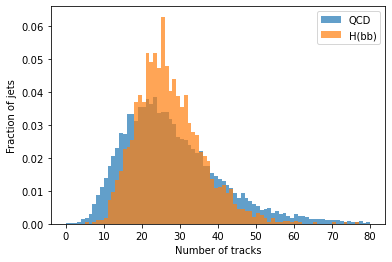

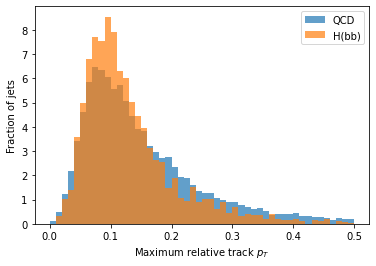

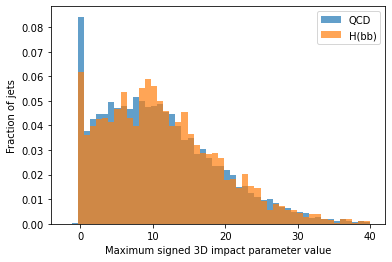

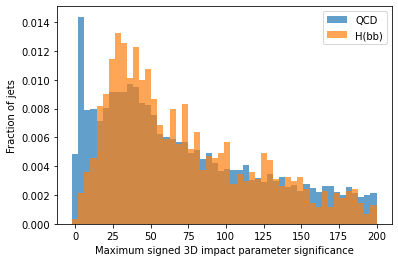

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# number of tracks
plt.figure()
plt.hist(track_features['track_pt'].counts,weights=label_QCD,bins=np.linspace(0,80,81),density=True,alpha=0.7,label='QCD')
plt.hist(track_features['track_pt'].counts,weights=label_Hbb,bins=np.linspace(0,80,81),density=True,alpha=0.7,label='H(bb)')
plt.xlabel('Number of tracks')
plt.ylabel('Fraction of jets')
plt.legend()

# max. relative track pt
plt.figure()
plt.hist(track_features['track_pt'].max()/jet_features['fj_pt'],weights=label_QCD,bins=np.linspace(0,0.5,51),density=True,alpha=0.7,label='QCD')
plt.hist(track_features['track_pt'].max()/jet_features['fj_pt'],weights=label_Hbb,bins=np.linspace(0,0.5,51),density=True,alpha=0.7,label='H(bb)')
plt.xlabel(r'Maximum relative track $p_{T}$')
plt.ylabel('Fraction of jets')
plt.legend()

# maximum signed 3D impact paramter value
plt.figure()
plt.hist(track_features['trackBTag_Sip3dVal'].max(),weights=label_QCD,bins=np.linspace(-2,40,51),density=True,alpha=0.7,label='QCD')
plt.hist(track_features['trackBTag_Sip3dVal'].max(),weights=label_Hbb,bins=np.linspace(-2,40,51),density=True,alpha=0.7,label='H(bb)')
plt.xlabel('Maximum signed 3D impact parameter value')
plt.ylabel('Fraction of jets')
plt.legend()

# maximum signed 3D impact paramter significance
plt.figure()
plt.hist(track_features['trackBTag_Sip3dSig'].max(),weights=label_QCD,bins=np.linspace(-2,200,51),density=True,alpha=0.7,label='QCD')
plt.hist(track_features['trackBTag_Sip3dSig'].max(),weights=label_Hbb,bins=np.linspace(-2,200,51),density=True,alpha=0.7,label='H(bb)')
plt.xlabel('Maximum signed 3D impact parameter significance')
plt.ylabel('Fraction of jets')
plt.legend()

plt.show()

## Visualize Separation of SV Features

Let's visualize the separation by plotting the signal and background for several track features that may be important.
- Number of secondary vertices 
- Maximum relative secondary vertex $p_T$ 
- Maximum relative secondary vertex mass

## ROC Curves
ROC curves can tell us how well each of these features discriminates betweeen signal and background.

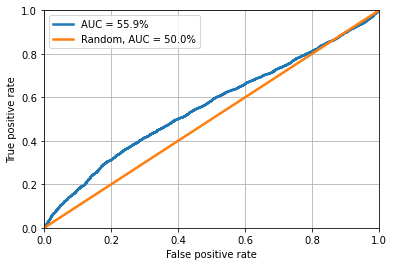

In [14]:
from sklearn.metrics import roc_curve, auc
disc = np.nan_to_num(track_features['track_pt'].max()/jet_features['fj_pt'],nan=0)

fpr, tpr, threshold = roc_curve(label_Hbb, disc)
# plot ROC curve
plt.figure()
plt.plot(tpr, fpr, lw=2.5, label="AUC = {:.1f}%".format(auc(tpr,fpr)*100))
plt.xlabel(r'False positive rate')
plt.ylabel(r'True positive rate')
#plt.semilogy()
plt.ylim(0,1)
plt.xlim(0,1)
plt.plot([0, 1], [0, 1], lw=2.5, label='Random, AUC = 50.0%')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

In [15]:
nsv_features = tree.arrays(branches=['nsv'],
                             entrystop=20000,
                             namedecode='utf-8')

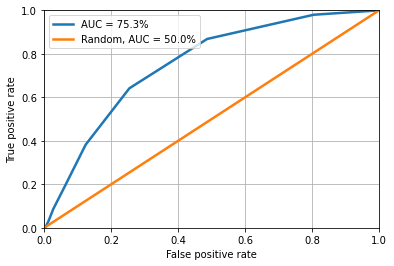

In [16]:
from sklearn.metrics import roc_curve, auc
disc = np.nan_to_num(nsv_features['nsv'],nan=0)

fpr, tpr, threshold = roc_curve(label_Hbb, disc)
# plot ROC curve
plt.figure()
plt.plot(fpr, tpr, lw=2.5, label="AUC = {:.1f}%".format(auc(fpr,tpr)*100))
plt.xlabel(r'False positive rate')
plt.ylabel(r'True positive rate')
#plt.semilogy()
plt.ylim(0,1)
plt.xlim(0,1)
plt.plot([0, 1], [0, 1], lw=2.5, label='Random, AUC = 50.0%')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

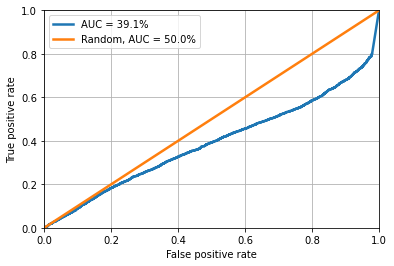

In [17]:
from sklearn.metrics import roc_curve, auc
disc = np.nan_to_num(sv_features['sv_mass'].max()/jet_features['fj_pt'],nan=0)

fpr, tpr, threshold = roc_curve(label_Hbb, disc)
# plot ROC curve
plt.figure()
plt.plot(tpr, fpr, lw=2.5, label="AUC = {:.1f}%".format(auc(tpr,fpr)*100))
plt.xlabel(r'False positive rate')
plt.ylabel(r'True positive rate')
#plt.semilogy()
plt.ylim(0,1)
plt.xlim(0,1)
plt.plot([0, 1], [0, 1], lw=2.5, label='Random, AUC = 50.0%')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

<ipython-input-18-2550c1cc79b4>:2: RuntimeWarning: divide by zero encountered in true_divide
  disc = np.nan_to_num(sv_features['sv_mass'].max()/jet_features['fj_sdmass'],nan=0)


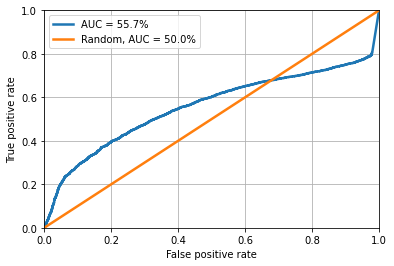

In [18]:
from sklearn.metrics import roc_curve, auc
disc = np.nan_to_num(sv_features['sv_mass'].max()/jet_features['fj_sdmass'],nan=0)

fpr, tpr, threshold = roc_curve(label_Hbb, disc)
# plot ROC curve
plt.figure()
plt.plot(tpr, fpr, lw=2.5, label="AUC = {:.1f}%".format(auc(tpr,fpr)*100))
plt.xlabel(r'False positive rate')
plt.ylabel(r'True positive rate')
#plt.semilogy()
plt.ylim(0,1)
plt.xlim(0,1)
plt.plot([0, 1], [0, 1], lw=2.5, label='Random, AUC = 50.0%')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

## Other engineered features
To read more about the features read this: http://opendata.cern.ch/record/12102

Here is a selection:


| Data variable | Type | Description |
| :---------------------- | -----------------: | :---------------------- |
| `event_no` | UInt_t | Event number |
| `npv` | Float_t | Number of reconstructed primary vertices (PVs) |
| `ntrueInt` | Float_t | True mean number of the poisson distribution for this event from which the number of interactions in each bunch crossing has been sampled |
| `rho` | Float_t | Median density (in GeV/A) of pile-up contamination per event; computed from all PF candidates of the event |
| `sample_isQCD` | Int_t | Boolean that is 1 if the simulated sample corresponds to QCD multijet production |
| `label_H_bb` | Int_t | Boolean that is 1 if a Higgs boson is matched and at least two b quarks are found within the AK8 jet |
| `label_QCD_bb` | Int_t | Boolean that is 1 if no resonances are matched and at least two b quarks are found within the AK8 jet |
| `label_QCD_b` | Int_t | Boolean that is 1 if no resonances are matched and only one b quark is found within the AK8 jet |
| `label_QCD_cc` | Int_t | Boolean that is 1 if no resonances are matched and at least two c quarks are found within the AK8 jet |
| `label_QCD_c` | Int_t | Boolean that is 1 if no resonances are matched and only one c quark is found within the AK8 jet |
| `label_QCD_others` | Int_t | Boolean that is 1 if no resonances are matched and no b or c quarks are found within the AK8 jet |
| `fj_doubleb` | Float_t | Double-b tagging discriminant based on a boosted decision tree calculated for the AK8 jet (see [CMS-BTV-16-002](http://cms-results.web.cern.ch/cms-results/public-results/publications/BTV-16-002/)) |
| `fj_eta` | Float_t | Pseudorapidity η of the AK8 jet |
| `fj_gen_eta` | Float_t | Pseudorapidity η of the generator-level, matched heavy particle: H, W, Z, top, etc. (default = -999) |
| `fj_gen_pt` | Float_t | Transverse momentum of the generator-level, geometrically matched heavy particle: H, W, Z, t, etc. (default = -999)  |
| `fj_isBB` | Int_t | Boolean that is 1 if two or more b hadrons are clustered within the AK8 jet (see [SWGuideBTagMCTools](https://twiki.cern.ch/twiki/bin/view/CMSPublic/SWGuideBTagMCTools)) |
| `fj_isNonBB` | Int_t | Boolean that is 1 if fewer than two b hadrons are clustered within the AK8 jet (see [SWGuideBTagMCTools](https://twiki.cern.ch/twiki/bin/view/CMSPublic/SWGuideBTagMCTools)) |
| `fj_nbHadrons` | Int_t | Number of b hadrons that are clustered within the AK8 jet (see [SWGuideBTagMCTools](https://twiki.cern.ch/twiki/bin/view/CMSPublic/SWGuideBTagMCTools)) |
| `fj_ncHadrons` | Int_t | Number of c hadrons that are clustered within the AK8 jet (see [SWGuideBTagMCTools](https://twiki.cern.ch/twiki/bin/view/CMSPublic/SWGuideBTagMCTools)) |
| `fj_isH` | Int_t | Boolean that is 1 if a generator-level Higgs boson and its daughters are geometrically matched to the AK8 jet |
| `fj_isTop` | Int_t | Boolean that is 1 if a generator-level top quark and its daughters are geometrically matched to the AK8 jet |
| `fj_isW` | Int_t | Boolean that is 1 if a generator-level W boson and its daughters are geometrically matched to the AK8 jet |
| `fj_isZ` | Int_t | Boolean that is 1 if a generator-level Z boson and its daughters are geometrically matched to the AK8 jet |
| `fj_isQCD` | Int_t | Boolean that is 1 if none of the above matching criteria are satisfied (H, top, W, Z) |
| `fj_label` | Int_t | Integer label: `Invalid=0,  Top_all=10, Top_bcq=11, Top_bqq=12, Top_bc=13, Top_bq=14, W_all=20, W_cq=21, W_qq=22, Z_all=30, Z_bb=31, Z_cc=32, Z_qq=33, H_all=40, H_bb=41, H_cc=42, H_qqqq=43, QCD_all=50, QCD_bb=51, QCD_cc=52, QCD_b=53, QCD_c=54, QCD_others=55` |
| `fj_labelJMAR` | Int_t | Alternative integer label from the CMS Jet/MET and Resolution (JMAR) group:  `Default=0, Top=1, W=2, Z=3, H=4` |
| `fj_labelLegacy` | Int_t | Alternative (legacy) integer label: `Default=0, Top=1, W=2, Z=3, H=4` |
| `fj_jetNTracks` | Float_t | Number of tracks associated with the AK8 jet |
| `fj_nSV` | Float_t | Number of SVs associated with the AK8 jet (∆R < 0.7) |
| `fj_n_sdsubjets` | Float_t | Number of soft drop subjets in the AK8 jet (up to 2) |
| `fj_mass` | Float_t | Ungroomed mass of the AK8 jet |
| `fj_phi` | Float_t | Azimuthal angle ϕ of the AK8 jet |
| `fj_pt` | Float_t | Transverse momentum of the AK8 jet |
| `fj_tau1` | Float_t | N-subjettiness variable for a 1-prong jet hypothesis |
| `fj_tau2` | Float_t | N-subjettiness variable for a 2-prong jet hypothesis |
| `fj_tau3` | Float_t | N-subjettiness variable for a 3-prong jet hypothesis |
| `fj_tau21` | Float_t | N-subjettiness variable for 2-prong vs 1-prong jet discrimination (`fj_tau2/fj_tau1`) |
| `fj_tau32` | Float_t | N-subjettiness variable for 3-prong vs 2-prong jet discrimination (`fj_tau3/fj_tau2`) |
| `fj_sdmass` | Float_t | Soft drop mass of the AK8 jet |
| `fj_ptDR` | Float_t | Transverse momentum times the ΔR between the two soft drop subjets |
| `fj_relptdiff` | Float_t | Absolute relative difference between the transverse momenta of the two softdrop subjets |
| `fj_sdn2` | Float_t | Fraction of second subjet transverse momentum times ∆R squared |
| `fj_sdsj1_axis1` | Float_t | First axis of the first subjet |
| `fj_sdsj1_axis2` | Float_t | Second axis of the first subjet |
| `fj_sdsj1_csv` | Float_t | Combined secondary vertex (CSV) b-tagging discriminant for the first subjet |
| `fj_sdsj1_eta` | Float_t | Pseudorapidity η of the first subjet |
| `fj_sdsj1_mass` | Float_t | Mass of the first subjet |
| `fj_sdsj1_mult` | Float_t | Particle multiplicity of the first subjet |
| `fj_sdsj1_phi` | Float_t | Azimuthal angle ϕ of the first subjet |
| `fj_sdsj1_pt` | Float_t | Transverse momentum of the first subjet |
| `fj_sdsj1_ptD` | Float_t | ptD variable, defined as the square root of the sum in quadrature of the transverse momentum of the subjet constituents divided by the scalar sum of the transverse momentum of the subjet constituents, for the first subjet (see [CMS-PAS-JME-13-002](https://cds.cern.ch/record/1599732)) |
| `fj_sdsj2_axis1` | Float_t | First axis of the first subjet |
| `fj_sdsj2_axis2` | Float_t | Second axis of the first subjet |
| `fj_sdsj2_csv` | Float_t | Combined secondary vertex (CSV) b-tagging discriminant for the first subject |
| `fj_sdsj2_eta` | Float_t | Pseudorapidity η of the second subjet |
| `fj_sdsj2_mass` | Float_t | Mass of the second subjet |
| `fj_sdsj2_mult` | Float_t | Particle multiplicity of the second subjet |
| `fj_sdsj2_phi` | Float_t | Azimuthal angle ϕ of the second subjet |
| `fj_sdsj2_pt` | Float_t | Transverse momentum of the second subjet |
| `fj_sdsj2_ptD` | Float_t | ptD variable, defined as the square root of the sum in quadrature of the transverse momentum of the subjet constituents divided by the scalar sum of the transverse momentum of the subjet constituents, for the second subjet (see [CMS-PAS-JME-13-002](https://cds.cern.ch/record/1599732)) |
| `fj_z_ratio` | Float_t | z ratio variable as defined in [CMS-BTV-16-002](http://cms-results.web.cern.ch/cms-results/public-results/publications/BTV-16-002/) |
| `fj_trackSipdSig_0` | Float_t | First largest track 3D signed impact parameter significance (see [CMS-BTV-16-002](http://cms-results.web.cern.ch/cms-results/public-results/publications/BTV-16-002/) ) |
| `fj_trackSipdSig_1` | Float_t | Second largest track 3D signed impact parameter significance (see [CMS-BTV-16-002](http://cms-results.web.cern.ch/cms-results/public-results/publications/BTV-16-002/) ) |
| `fj_trackSipdSig_2` | Float_t | Third largest track 3D signed impact parameter significance (see [CMS-BTV-16-002](http://cms-results.web.cern.ch/cms-results/public-results/publications/BTV-16-002/) )  |
| `fj_trackSipdSig_3` | Float_t | Fourth largest track 3D signed impact parameter significance (see [CMS-BTV-16-002](http://cms-results.web.cern.ch/cms-results/public-results/publications/BTV-16-002/) )  |
| `fj_trackSipdSig_0_0` | Float_t | First largest track 3D signed impact parameter significance associated to the first N-subjettiness axis |
| `fj_trackSipdSig_0_1` | Float_t | Second largest track 3D signed impact parameter significance associated to the first N-subjettiness axis |
| `fj_trackSipdSig_1_0` | Float_t | First largest track 3D signed impact parameter significance associated to the second N-subjettiness axis |
| `fj_trackSipdSig_1_1` | Float_t | Second largest track 3D signed impact parameter significance associated to the second N-subjettiness axis |
| `fj_trackSip2dSigAboveCharm_0` | Float_t | Track 2D signed impact parameter significance of the first track lifting the combined invariant mass of the tracks above the c hadron threshold mass (1.5 GeV) |
| `fj_trackSip2dSigAboveBottom_0` | Float_t | Track 2D signed impact parameter significance of the first track lifting the combined invariant mass of the tracks above b hadron threshold mass (5.2 GeV) |
| `fj_trackSip2dSigAboveBottom_1` | Float_t | Track 2D signed impact parameter significance of the second track lifting the combined invariant mass of the tracks above b hadron threshold mass (5.2 GeV) |
| `fj_tau0_trackEtaRel_0` | Float_t | Smallest track pseudorapidity ∆η, relative to the jet axis, associated to the first N-subjettiness axis |
| `fj_tau0_trackEtaRel_1` | Float_t | Second smallest track pseudorapidity ∆η, relative to the jet axis, associated to the first N-subjettiness axis |
| `fj_tau0_trackEtaRel_2` | Float_t | Third smallest track pseudorapidity ∆η, relative to the jet axis, associated to the first N-subjettiness axis |
| `fj_tau1_trackEtaRel_0` | Float_t | Smallest track pseudorapidity ∆η, relative to the jet axis, associated to the second N-subjettiness axis |
| `fj_tau1_trackEtaRel_1` | Float_t | Second smallest track pseudorapidity ∆η, relative to the jet axis, associated to the second N-subjettiness axis |
| `fj_tau1_trackEtaRel_2` | Float_t | Third smallest track pseudorapidity ∆η, relative to the jet axis, associated to the second N-subjettiness axis |
| `fj_tau_vertexMass_0` | Float_t | Total SV mass for the first N-subjettiness axis, defined as the invariant mass of all tracks from SVs associated with the first N-subjettiness axis |
| `fj_tau_vertexMass_1` | Float_t | Total SV mass for the second N-subjettiness axis, defined as the invariant mass of all tracks from SVs associated with the second N-subjettiness axis |
| `fj_tau_vertexEnergyRatio_0` | Float_t | SV vertex energy ratio for the first N-subjettiness axis, defined as the total energy of all SVs associated with the first N-subjettiness axis divided by the total energy of all the tracks associated with the AK8 jet that are consistent with the PV |
| `fj_tau_vertexEnergyRatio_1` | Float_t | SV energy ratio for the second N-subjettiness axis, defined as the total energy of all SVs associated with the first N-subjettiness axis divided by the total energy of all the tracks associated with the AK8 jet that are consistent with the PV |
| `fj_tau_flightDistance2dSig_0` | Float_t | Transverse (2D) flight distance significance between the PV and the SV with the smallest uncertainty on the 3D flight distance associated to the first N-subjettiness axis |
| `fj_tau_flightDistance2dSig_1` | Float_t | Transverse (2D) flight distance significance between the PV and the SV with the smallest uncertainty on the 3D flight distance associated to the second N-subjettiness axis |
| `fj_tau_vertexDeltaR_0` | Float_t | Pseudoangular distance ∆R between the first N-subjettiness axis and SV direction |
| `n_pfcands` | Int_t | Number of particle flow (PF) candidates associated to the AK8 jet with transverse momentum greater than 0.95 GeV |
| `npfcands` | Float_t | Number of particle flow (PF) candidates associated to the AK8 jet with transverse momentum greater than 0.95 GeV |
| `pfcand_VTX_ass` | Int_t | PV association quality for the PF candiate: `UsedInFitTight=7`, the track is used in the PV fit and the weight is above 0.5; `UsedInFitLoose=6`,  the track is used in the PV fit and the weight is below 0.5; `CompatibilityDz=5` the track is not used in fit but is very close in `dz` to the PV (`dzsig` < 5 or `dz` < 300 um); `CompatibilityBTag=4`, the track is not compatible with the PV but it is close to the nearest jet axis starting from the PV (distance to jet axis < 700 um); `NotReconstructedPrimary=0`, the track is not associated to any PV and is compatible with the beam spot hence it is likely to be originating from an interaction for which we did not reconstruct the PV (beam spot compatibility: `dxysig` < 2 and `dxy` < 200 um); `OtherDeltaZ=1`, none of the above criteria is satisfied, hence the closest in `dz` vertex is associated) |
| `pfcand_charge` | Float_t | Electric charge of the PF candidate  |
| `pfcand_deltaR` | Float_t | Pseudoangular distance ∆R between the PF candidate and the AK8 jet axis |
| `pfcand_drminsv` | Float_t | Minimum pseudoangular distance ∆R between the associated SVs and the PF candidate |
| `pfcand_drsubjet1` | Float_t | Pseudoangular distance ∆R between the PF candidate and the first soft drop subjet |
| `pfcand_drsubjet2` | Float_t | Pseudoangular distance ∆R between the PF candidate and the second soft drop subjet |
| `pfcand_dxy` | Float_t | Transverse (2D) impact paramater of the PF candidate, defined as the distance of closest approach of the PF candidate trajectory to the beam line in the transverse plane to the beam |
| `pfcand_dxysig` | Float_t | Transverse (2D) impact paramater significance of the PF candidate |
| `pfcand_dz` | Float_t | Longitudinal impact parameter, defined as the distance of closest approach of the PF candidate trajectory to the PV projected on to the z direction |
| `pfcand_dzsig` | Float_t | Longitudinal impact parameter significance of the PF candidate |
| `pfcand_erel` | Float_t | Energy of the PF candidate divided by the energy of the AK8 jet |
| `pfcand_etarel` | Float_t | Pseudorapidity of the PF candidate relative to the AK8 jet axis |
| `pfcand_phirel` | Float_t | Azimuthal angular distance ∆ϕ between the PF candidate and the AK8 jet axis |
| `pfcand_ptrel` | Float_t | Transverse momentum of the PF candidate divided by the transverse momentum of the AK8 jet |
| `pfcand_fromPV` | Float_t | Integer indicating whether the PF candidate is consistent with the PV: `PVUsedInFit=3`, if the track is used in the PV fit; `PVTight=2` if the track is not used in the fit of any of the other PVs and is closest in z to the PV, `PVLoose=1` if the track is closest in z to a PV other then the PV; `NoPV=0` if the track is used in the fit of another PV |
| `pfcand_hcalFrac` | Float_t | Fraction of energy of the PF candidate deposited in the hadron calorimeter |
| `pfcand_isChargedHad` | Float_t | Boolean that is 1 if the PF candidate is classified as a charged hadron |
| `pfcand_isEl` | Float_t | Boolean that is 1 if the PF candidate is classified as an electron |
| `pfcand_isGamma` | Float_t | Boolean that is 1 if the PF candidate is classified as an photon |
| `pfcand_isMu` | Float_t | Boolean that is 1 if the PF candidate is classified as an muon |
| `pfcand_isNeutralHad` | Float_t | Boolean that is 1 if the PF candidate is classified as a neutral hadron |
| `pfcand_lostInnerHits` | Float_t | Integer with information related to inner silicon tracker hits for the PF candidate: `validHitInFirstPixelBarrelLayer=-1`, if the track has a valid hit in the first pixel barrel layer; `noLostInnerHits=0` if it does not have such hit because of geometrical or detector inefficiencies (i.e. the hit wasn't expected to be there); `oneLostHit=1`, if the track extrapolation towards the beam line crosses an active detector but no hit is found there; `moreLostHits=2` if there are at least two missing expected inner hits |
| `pfcand_mass` | Float_t | Mass of the PF candidate |
| `pfcand_puppiw` | Float_t | Pileup per-particle identification (PUPPI) weight indicating whether the PF candidate is pileup-like (0) or not (1) |
| `n_tracks` | Int_t | Number of tracks associated with the AK8 jet |
| `ntracks` | Float_t | Number of tracks associated with the AK8 jet |
| `trackBTag_DeltaR` | Float_t | Pseudoangular distance ∆R between the track and the AK8 jet axis |
| `trackBTag_Eta` | Float_t | Pseudorapidity η of the track |
| `trackBTag_EtaRel` | Float_t | Pseudorapidity ∆η of the track relative the AK8 jet axis |
| `trackBTag_JetDistVal` | Float_t | Minimum track approach distance to the AK8 jet axis |
| `trackBTag_Momentum` | Float_t | Momentum of the track |
| `trackBTag_PPar` | Float_t | Component of track momentum parallel to the AK8 jet axis |
| `trackBTag_PParRatio` | Float_t | Component of track momentum parallel to the AK8 jet axis, normalized to the track momentum |
| `trackBTag_PtRatio` | Float_t | Component of track momentum perpendicular to the AK8 jet axis, normalized to the track momentum |
| `trackBTag_PtRel` | Float_t | Component of track momentum perpendicular to the AK8 jet axis |
| `trackBTag_Sip2dVal` | Float_t | Transverse (2D) signed impact paramater of the track |
| `trackBTag_Sip2dSig` | Float_t | Transverse (2D) signed impact paramater significance of the track |
| `trackBTag_Sip3dSig` | Float_t | 3D signed impact parameter significance of the track |
| `trackBTag_Sip3dVal` | Float_t | 3D signed impact parameter of the track |
| `track_VTX_ass` | Float_t | PV association quality for the track: `UsedInFitTight=7`, the track is used in the PV fit and the weight is above 0.5; `UsedInFitLoose=6`, the track is used in the PV fit and the weight is below 0.5; `CompatibilityDz=5` the track is not used in fit but is very close in `dz` to the PV (`dzsig` < 5 or `dz` < 300 um); `CompatibilityBTag=4`, the track is not compatible with the PV but it is close to the nearest jet axis starting from the PV (distance to jet axis < 700 um); `NotReconstructedPrimary=0`, the track is not associated to any PV and is compatible with the BeamSpot hence it is likely to be originating from an interaction for which we did not reconstruct the PV (beam spot compatibility: `dxysig` < 2 and `dxy` < 200 um); `OtherDeltaZ=1`, none of the above criteria is satisfied, hence the closest in dZ vertex is associated) |
| `track_charge` | Float_t | Electric charge of the charged PF candidate |
| `track_deltaR` | Float_t | Pseudoangular distance (∆R) between the charged PF candidate and the AK8 jet axis |
| `track_detadeta` | Float_t | Track covariance matrix entry (eta, eta) |
| `track_dlambdadz` | Float_t | Track covariance matrix entry (lambda, dz)  |
| `track_dphidphi` | Float_t | Track covariance matrix entry (phi, phi)  |
| `track_dphidxy` | Float_t | Track covariance matrix entry (phi, xy) |
| `track_dptdpt` | Float_t | Track covariance matrix entry (pT, pT) |
| `track_dxydxy` | Float_t | Track covariance matrix entry (dxy, dxy)  |
| `track_dxydz` | Float_t | Track covariance matrix entry (dxy, dz) |
| `track_dzdz` | Float_t | Track covariance matrix entry (dz, dz) |
| `track_drminsv` | Float_t | Minimum pseudoangular distance ∆R between the associated SVs and the charged PF candidate |
| `track_drsubjet1` | Float_t | Pseudoangular distance ∆R between the charged PF candidate and the first soft drop subjet |
| `track_drsubjet2` | Float_t | Pseudoangular distance ∆R between the charged PF candidate and the second soft drop subjet  |
| `track_dxy` | Float_t | Transverse (2D) impact parameter of the track, defined as the distance of closest approach of the track trajectory to the beam line in the transverse plane to the beam |
| `track_dxysig` | Float_t | Transverse (2D) impact parameter significance of the track |
| `track_dz` | Float_t | Longitudinal impact parameter, defined as the distance of closest approach of the track trajectory to the PV projected on to the z direction |
| `track_dzsig` | Float_t | Longitudinal impact parameter significance of the track |
| `track_erel` | Float_t | Energy of the charged PF candidate divided by the energy of the AK8 jet |
| `track_etarel` | Float_t | Pseudorapidity ∆η of the track relative to the jet axis |
| `track_fromPV` | Float_t | Integer indicating whether the charged PF candidate is consistent with the PV: `PVUsedInFit=3`, if the track is used in the PV fit; `PVTight=2` if the track is not used in the fit of any of the other PVs and is closest in z to the PV, `PVLoose=1` if the track is closest in z to a PV other then the PV; `NoPV=0` if the track is used in the fit of another PV |
| `track_isChargedHad` | Float_t | Boolean that is 1 if the charged PF candidate is classified as a charged hadron |
| `track_isEl` | Float_t | Boolean that is 1 if the charged PF candidate is classified as an electron  |
| `track_isMu` | Float_t | Boolean that is 1 if the charged PF candidate is classified as a muon |
| `track_lostInnerHits` | Float_t | Integer with information related to inner silicon tracker hits for the track: `validHitInFirstPixelBarrelLayer=-1`, if the track has a valid hit in the first pixel barrel layer; `noLostInnerHits=0` if it does not have such hit because of geometrical or detector inefficiencies (i.e. the hit wasn't expected to be there); `oneLostHit=1`, if the track extrapolation towards the beam line crosses an active detector but no hit is found there; `moreLostHits=2` if there are at least two missing expected inner hits |
| `track_mass` | Float_t | Mass of the charged PF candidate |
| `track_normchi2` | Float_t | Normalized χ2 of the track fit |
| `track_phirel` | Float_t | Azimuthal angular distance ∆ϕ between the charged PF candidate and the AK8 jet axis |
| `track_pt` | Float_t | Transverse momentum of the charged PF candidate |
| `track_ptrel` | Float_t | Transverse momentum of the charged PF candidate divided by the transverse momentum of the AK8 jet |
| `track_puppiw` | Float_t | Pileup per-particle identification (PUPPI) weight indicating whether the PF candidate is pileup-like (0) or not (1)  |
| `track_quality` | Float_t | Track quality: `undefQuality=-1`; `loose=0`; `tight=1`; `highPurity=2`; `confirmed=3`, if track found by more than one iteration; `looseSetWithPV=5`; `highPuritySetWithPV=6`, `discarded=7` if a better track found; `qualitySize=8` |
| `n_sv` | Int_t | Number of secondary vertices (SV) associated with the AK8 jet (∆R < 0.8) |
| `nsv` | Float_t | Number of secondary vertices (SV) associated with the AK8 jet (∆R < 0.8)|
| `sv_chi2` | Float_t | χ2 of the vertex fit |
| `sv_ndf` | Float_t | number of degrees of freedom of the vertex fit |
| `sv_normchi2` | Float_t | χ2 divided by the number of degrees of freedom for the vertex fit |
| `sv_costhetasvpv` | Float_t | Cosine of the angle cos(θ) between the SV and the PV |
| `sv_d3d` | Float_t | 3D flight distance of the SV |
| `sv_d3derr` | Float_t | 3D flight distance uncertainty of the SV |
| `sv_d3dsig` | Float_t | 3D flight distance significance of the SV |
| `sv_dxy` | Float_t | Transverse (2D) flight distance of the SV |
| `sv_dxyerr` | Float_t | Transverse (2D) flight distance uncertainty of the SV |
| `sv_dxysig` | Float_t | Transverse (2D) flight distance significance of the SV |
| `sv_deltaR` | Float_t | Pseudoangular distance ∆R between the SV and the AK8 jet |
| `sv_erel` | Float_t | Energy of the SV divided by the energy of the AK8 jet |
| `sv_etarel` | Float_t | Pseudorapidity ∆η of the SV relative to the AK8 jet axis |
| `sv_mass` | Float_t | Mass of the SV |
| `sv_ntracks` | Float_t | Number of tracks associated with the SV |
| `sv_phirel` | Float_t | Azimuthal angular distance ∆ϕ of the SV relative to the jet axis |
| `sv_pt` | Float_t | Transverse momentum of the SV |
| `sv_ptrel` | Float_t | Transverse momentum of the SV divided by the transverse momentum of the AK8 jet |